# ML Project phase 2 - OneByOne
---


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# !pip install contractions
# import contractions
import re
# import nltk
import tensorflow as tf
# !pip install gensim
import gensim
# from nltk.corpus import stopwords

In [2]:
%config Completer.use_jedi = False

df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')
np.random.seed(0)
train_ratio = 808998/len(df)
msk = np.random.rand(len(df)) <= train_ratio

data = df[msk]
test = df[~msk]

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('drive/MyDrive/Temp/sarcasm_train_set.csv')

# !cp '../content/drive/MyDrive/Kaggle/projectPhase2_dataset.zip' '/content'
# !unzip -q 'projectPhase2_dataset.zip'
# # data = pd.read_csv('drive/MyDrive/drive/MyDrive/sarcasm_train_set.csv')
# data = pd.read_csv('sarcasm_train_set.csv')

In [4]:
data.dropna(subset=['comment'], inplace=True)
data.isna().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [5]:
# from nltk.corpus import stopwords
# nltk.download('wordnet')
# nltk.download('stopwords')

# def preprocess(data, remove_stop_words=False, remove_special=False):
#     pre_data = data.apply(lambda x : contractions.fix(x))
#     if remove_special:
#         pre_data = pre_data.apply(lambda x: re.sub('[^a-zA-Z0-9]+', ' ', x))

#     lemmatizer = nltk.stem.WordNetLemmatizer()
#     for pos_tag in ['v', 'n', 'a']: # v for verbs, n for nouns and a for adverbs
#         pre_data = pre_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(w, pos_tag) for w in text.split()]) )

#     if remove_stop_words:
#         stop_words = set(stopwords.words('english'))
#         pre_data = pre_data.apply(lambda text: ' '.join(word for word in text.split() if not word.lower() in stop_words))
#     return pre_data

In [6]:
def replace_zero_length(pre_data):
    k = np.where(pre_data.apply(lambda x: len(x) == 0))[0]
    print(len(k))
    pre_data.iloc[k] = 'None'
    return pre_data


raw_data = data['comment']
# pre_data = replace_zero_length(preprocess(data['comment']))

# pre_sentences = [[word for word in document.lower().split()] for document in pre_data]
raw_sentences = [[word for word in document.lower().split()] for document in raw_data]

## Embedding 


* **Word2Vec**

In [7]:
# pre_embed = gensim.models.Word2Vec(pre_sentences, vector_size=100, window=5, min_count=1)
raw_embed = gensim.models.Word2Vec(raw_sentences, vector_size=100, window=5, min_count=1, )

In [8]:
def get_word2vec_enc(comments, embed):
    encoded_comments = []
    for comment in comments:
        word2vec_embedding = embed.wv[comment]
        encoded_comments.append(word2vec_embedding)
    return encoded_comments
        
def word2vec_padding(df, embed):    
    encoded_comment = get_word2vec_enc(df,embed)
    padded_encoded_comments = tf.keras.preprocessing.sequence.pad_sequences(encoded_comment, maxlen=100, dtype="float64", padding='post')
    X = np.array(padded_encoded_comments)
    return X

In [9]:
# w2v_pre_x = word2vec_padding(pre_sentences[0:10000], pre_embed)
# w2v_raw_x = word2vec_padding(raw_sentences[0:10000], raw_embed)

* **TF-IDF:**

In [10]:
# from sklearn.feature_extraction.text import TfidfVectorizer
 
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
# raw_x_itf = vectorizer.fit_transform(raw_data)

# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
# pre_x_itf = vectorizer.fit_transform(pre_data)

---

* **Custom deep neural network:**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt
import sys
!pip install colorama
import colorama
from collections import OrderedDict
from matplotlib import pyplot as plt 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.set_printoptions(precision=3)
import os
import sklearn.metrics as met


In [12]:
y=data['label']
# dset = []
# for i, mat in enumerate(w2v_raw_x):
#     t = torch.from_numpy(mat)
#     dset.append((t, y[i]))

In [13]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, embed, sentences, labels):
        self.embed = embed
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        vec = word2vec_padding([self.sentences[idx]], self.embed)[0]
        return torch.from_numpy(vec).unsqueeze(0), self.labels.iloc[idx]


train_data = CustomDataset(raw_embed, raw_sentences, y)

In [14]:
from torch.utils.data import DataLoader

def sampler(dataset):
    return SubsetRandomSampler(np.random.choice(np.array(list(range(len(dataset)))),\
                                                    size=len(dataset), replace=False))

def loader(dataset, sampler=None):
    samp = None
    if sampler is not None:
        samp = sampler
    else:
        samp = sampler(dataset)
    return DataLoader(dataset, 
                      batch_size = batch_size,
                      sampler = samp,
                      num_workers = num_workers)

val_size = 0.15
num_workers = 4
batch_size = 512

# creating train and validation data samples:
num = len(train_data)
sp = int(val_size * num)
ind = list(range(num))
np.random.shuffle(ind)
val_ind, train_ind = ind[:sp], ind[sp:]
train_samp, val_samp = SubsetRandomSampler(train_ind), SubsetRandomSampler(val_ind)

train_loader = loader(train_data, train_samp)
val_loader = loader(train_data, val_samp)

In [15]:
next(iter(train_loader))[0].shape

torch.Size([512, 1, 100, 100])

In [16]:
class N_net(nn.Module):
    def __init__(self):
        super(N_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 100), stride=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.bnorm = nn.BatchNorm2d(num_features=4)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=2)        
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 1), stride=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1), stride=2)
        self.fc = nn.Linear(in_features=92, out_features=2)

    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.conv1(x)
        out = self.bnorm(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.bnorm(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        out = F.softmax(out)
        return out

In [17]:
nn_model = N_net()

In [18]:
test_input = torch.randn(1, 1, 100, 100) 
out = nn_model(test_input)
print("out.shape: \n%s" % (out.shape,))

out.shape: 
torch.Size([1, 2])


In [23]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import gc
test_acc_all, train_acc_all, val_acc_all, train_loss_all = [], [], [], []
acc_all, f1_all, prec_all, rec_all = [], [], [], []

def train_cnn(model, train_loader, test_loader, val_loader, device, num_epochs, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.2, patience=4, verbose=True)
    blocks, best_acc = 0, 0
    for epoch in range(num_epochs):
        print("=" * 25, "Starting epoch %d" % (epoch + 1), "=" * 25)
        names = ['train_loader']
        for d_idx, dataloader in enumerate([train_loader]):
            for batch_idx, (data, labels) in enumerate(dataloader):
                if batch_idx % 5 == 0:
                    gc.collect()
                model.train()
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[:, 1].to(torch.float64), labels.to(torch.float64))
                loss.backward()
                optimizer.step()
                if batch_idx % 500 == 0:
                    print("\nstarting batch %d/%d, Loss=%.4f" % (batch_idx, len(dataloader), loss.item()))
#                     print('on: ', names[d_idx])
                    train_acc = accuracy(model, train_loader, device)
#                     val_acc = accuracy(model, val_loader, device)
#                     test_acc = accuracy(model, test_loader, device)
                    val_acc, f1, prec, rec = score(model, val_loader, device)
                    acc_all.append(val_acc); f1_all.append(f1); prec_all.append(prec); rec_all.append(rec);
                    train_acc_all.append(train_acc); val_acc_all.append(val_acc); train_loss_all.append(loss.item());
                    gc.collect()
                    if val_acc > best_acc:
                        torch.save(model.state_dict(), 'model.pt')
                        best_acc = val_acc
                    print(colorama.Fore.GREEN, "Accuracy on training: %.2f%%" % (100*train_acc))
                    print("Accuracy on val: %.2f%%" % (100*val_acc))                
#                     print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET) 
#                     print(f'F1 score on test : {100*f1:.2f}')
#                     print(f'Precision score on test : {100*prec:.2f}')
#                     print(f'Recall score on test : {100*rec:.2f}', colorama.Fore.RESET)
#                     test_acc_all.append(test_acc); 

                    blocks += 1
                    plot_train(val_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks)
                    plot_scores(acc_all, f1_all, prec_all, rec_all, epoch=blocks)
                    scheduler.step(val_acc)
                    

In [24]:
def accuracy(model, dataloader, device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data).max(1)[1]
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
    return num_correct / num_samples

def print_score(y_test, pred):
    print('Accuracy:  ', met.accuracy_score(y_test, pred))
    print('F1_score:  ', met.f1_score(y_test, pred))
    print('Precision: ', met.precision_score(y_test, pred))
    print('Recall:    ', met.recall_score(y_test, pred))
    
def score(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    print_score(y_test, pred)
    return met.accuracy_score(y_test, pred), met.f1_score(y_test, pred),\
    met.precision_score(y_test, pred),\
    met.recall_score(y_test, pred)

def plot_conmat(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    c = met.confusion_matrix(y_test, pred)
    disp = met.ConfusionMatrixDisplay(c)
    plt.figure(figsize=(10, 6))
    disp.plot()

In [25]:
def plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks):
    plt.figure(figsize=(10, 6))
    x = np.arange(blocks)
    plt.plot(x, train_acc_all, label='train accuracy');
    plt.plot(x, val_acc_all, label='validation accuracy');
#     plt.plot(x, test_acc_all, label='test accuracy');
#     plt.plot(reg, mean_f1, label='F1_score');
    plt.xlabel('250-Batch training blocks');
    plt.ylabel('Model accuracy');
    plt.title('Model prediction accuracy by training batches');
    plt.legend();
    plt.show();
    
def plot_scores(acc_all, f1_all, prec_all, rec_all, epoch):
    plt.figure(figsize=(10, 6))
    x = np.arange(epoch)
    plt.plot(x, acc_all, label='val accuracy');
    plt.plot(x, f1_all, label='val F1 score');
    plt.plot(x, prec_all, label='val precision');
    plt.plot(x, rec_all, label='val recall');
    plt.xlabel('Number of 250-Batch training blocks');
    plt.ylabel('Model scores');
    plt.title('Model prediction scores on validation data by training epochs');
    plt.legend();
    plt.show();

========================= Starting epoch 1 =========================

starting batch 0/1343, Loss=0.7567
Accuracy:   0.48457034471383803
F1_score:   0.487675724414935
Precision:  0.4835809734369412
Recall:     0.49184041269158907
 Accuracy on training: 48.40%
Accuracy on val: 48.46%


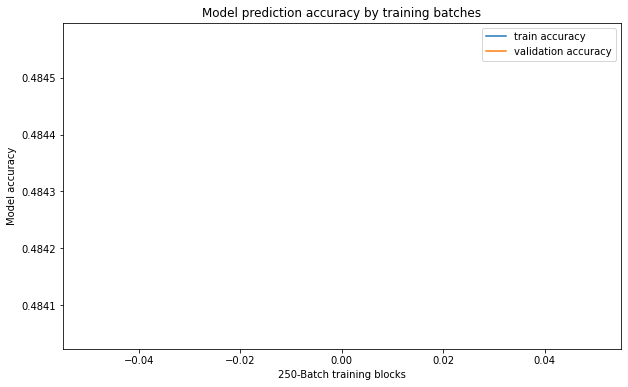

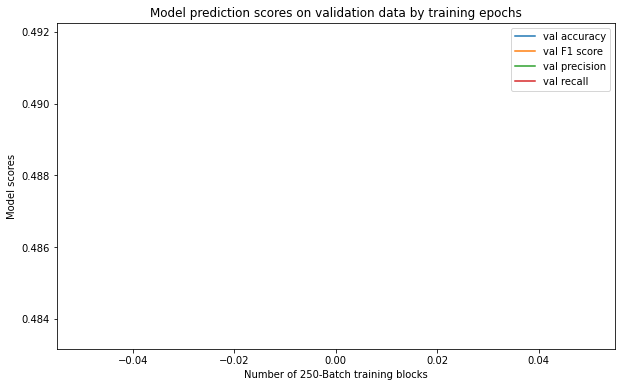


starting batch 500/1343, Loss=0.5901
Accuracy:   0.6351311232063335
F1_score:   0.5243194426525609
Precision:  0.7495619562878485
Recall:     0.4031679370380781
 Accuracy on training: 63.48%
Accuracy on val: 63.51%


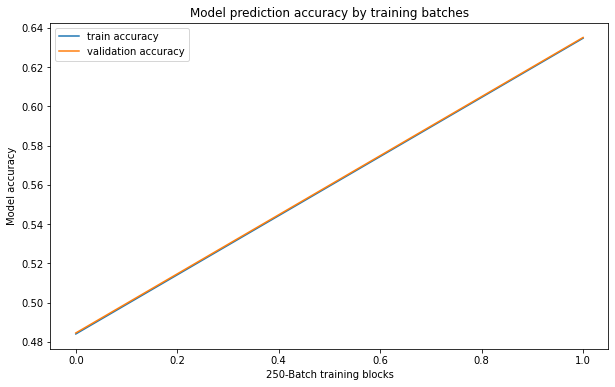

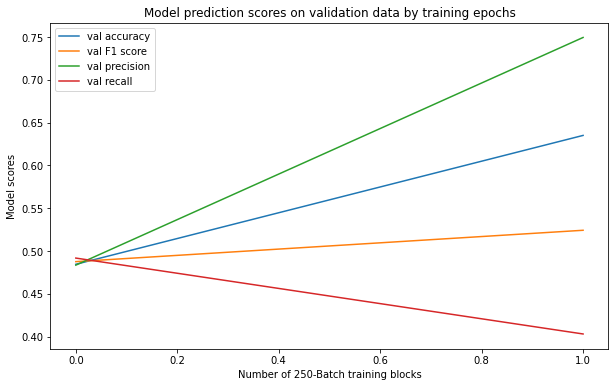


starting batch 1000/1343, Loss=0.6392
Accuracy:   0.6529028533729176
F1_score:   0.5673016623659671
Precision:  0.7499592280511008
Recall:     0.45619285395413434
 Accuracy on training: 65.15%
Accuracy on val: 65.29%


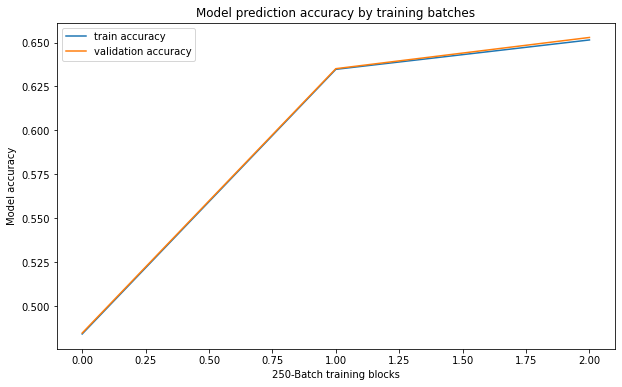

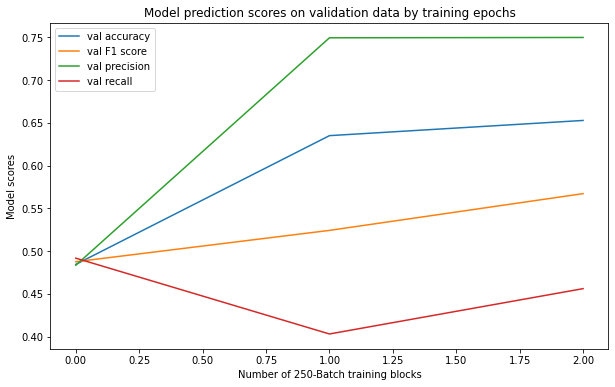

========================= Starting epoch 2 =========================

starting batch 0/1343, Loss=0.6216
Accuracy:   0.6633102424542305
F1_score:   0.5968460239559984
Precision:  0.7409287045209375
Recall:     0.49967758469602025
 Accuracy on training: 66.29%
Accuracy on val: 66.33%


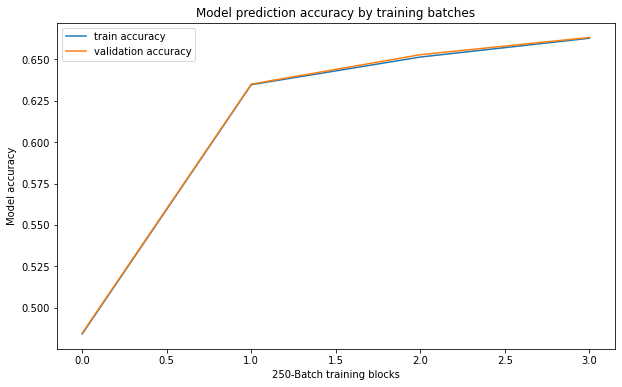

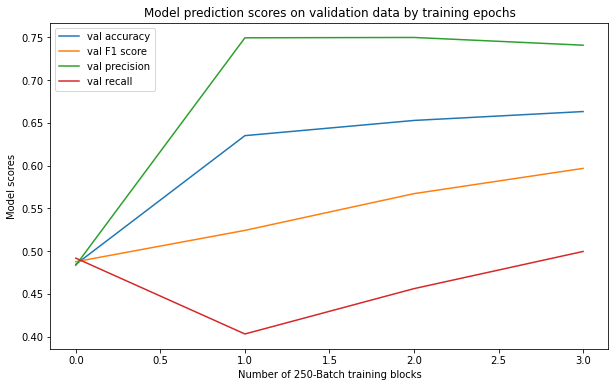


starting batch 500/1343, Loss=0.5974
Accuracy:   0.6414728682170543
F1_score:   0.526988064540697
Precision:  0.7705377028316894
Recall:     0.4004232734247119
 Accuracy on training: 64.14%
Accuracy on val: 64.15%


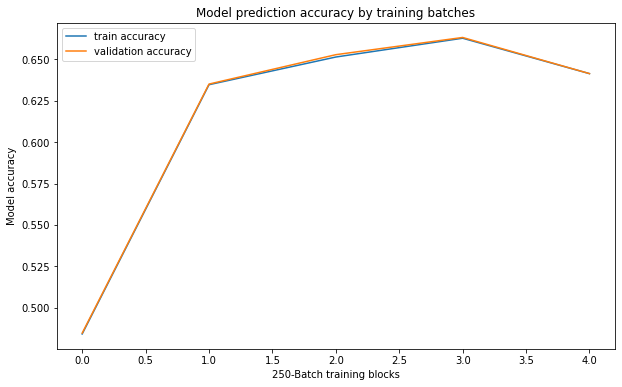

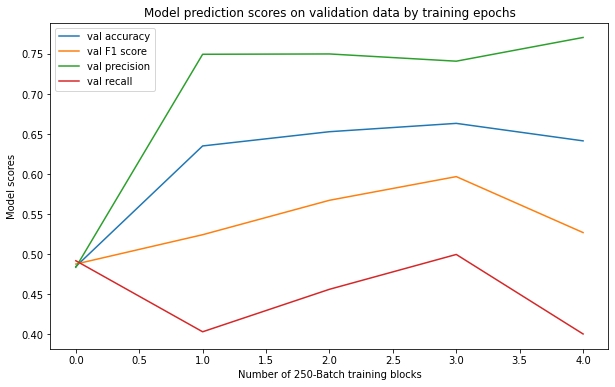


starting batch 1000/1343, Loss=0.6304
Accuracy:   0.6523915553356424
F1_score:   0.556720546014786
Precision:  0.7648231622746186
Recall:     0.4376415733866834
 Accuracy on training: 65.19%
Accuracy on val: 65.24%


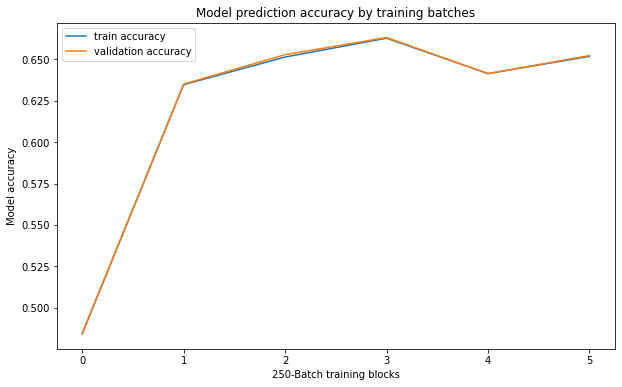

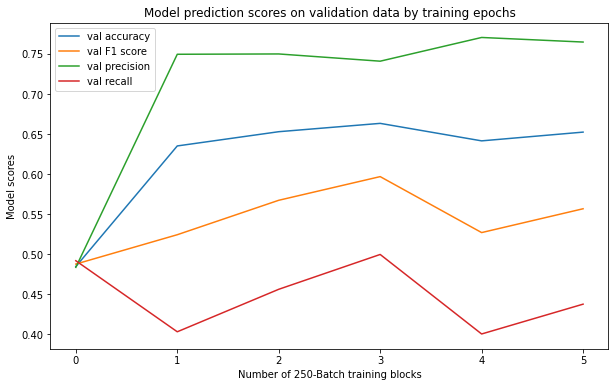

========================= Starting epoch 3 =========================

starting batch 0/1343, Loss=0.5916
Accuracy:   0.6516081147946561
F1_score:   0.5470472187674229
Precision:  0.7780827767102815
Recall:     0.42180188819629305
 Accuracy on training: 65.09%
Accuracy on val: 65.16%


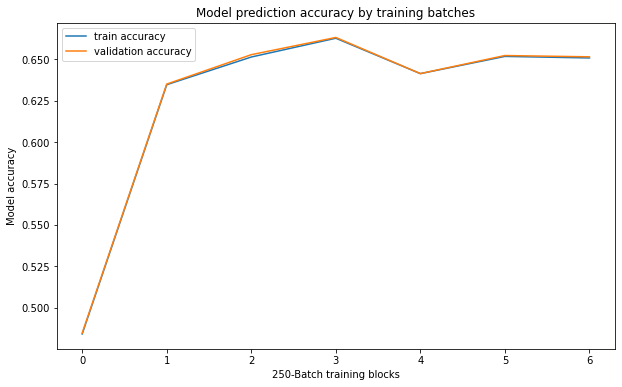

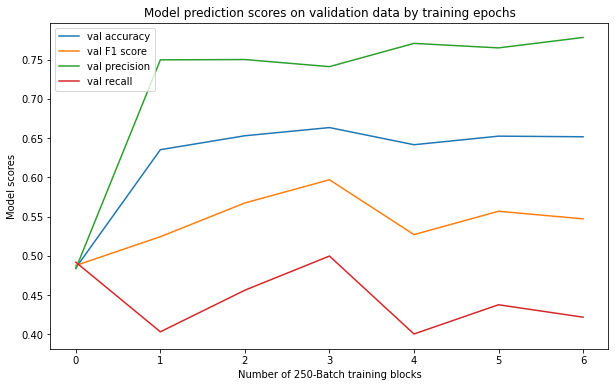


starting batch 500/1343, Loss=0.5724
Accuracy:   0.6311232063334983
F1_score:   0.4847011658448919
Precision:  0.7991870227557649
Recall:     0.34782824358062864
 Accuracy on training: 63.17%
Accuracy on val: 63.11%


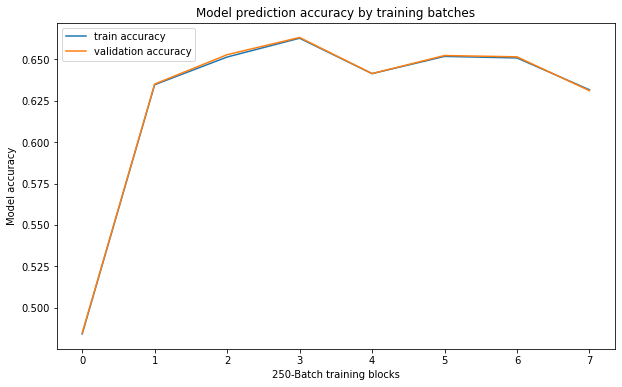

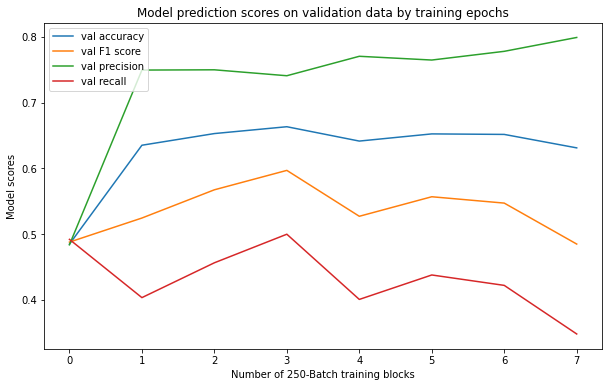


starting batch 1000/1343, Loss=0.6140
Accuracy:   0.6625515421408543
F1_score:   0.5810184000081914
Precision:  0.7630573933623797
Recall:     0.46910600023147764
 Accuracy on training: 66.23%
Accuracy on val: 66.26%


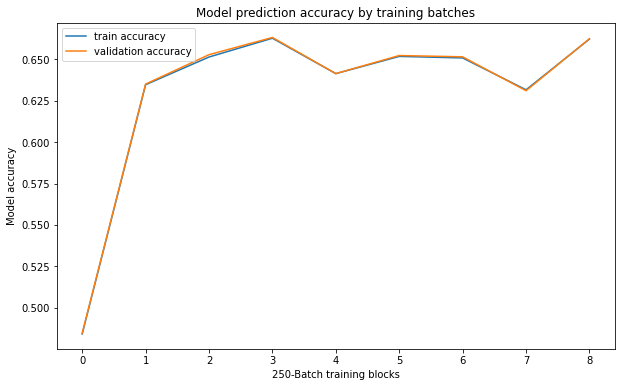

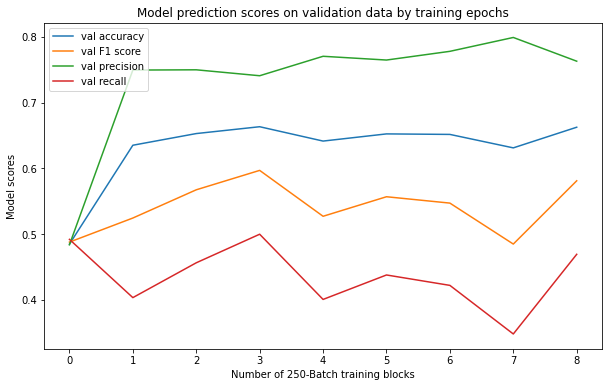

Epoch     9: reducing learning rate of group 0 to 2.0000e-04.
========================= Starting epoch 4 =========================

starting batch 0/1343, Loss=0.5916
Accuracy:   0.6551212271152894
F1_score:   0.5603355831703778
Precision:  0.7693795652048387
Recall:     0.4406177146541889
 Accuracy on training: 65.49%
Accuracy on val: 65.51%


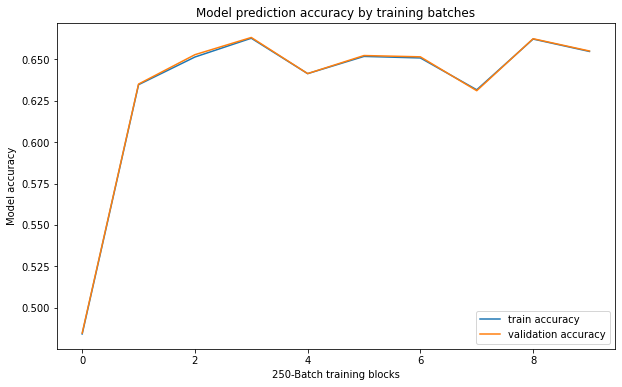

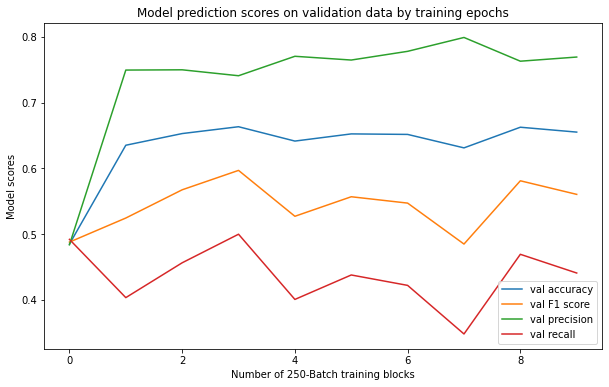


starting batch 500/1343, Loss=0.6167
Accuracy:   0.6611660893946891
F1_score:   0.5758848849572138
Precision:  0.7664303769645016
Recall:     0.46121922587258807
 Accuracy on training: 66.06%
Accuracy on val: 66.12%


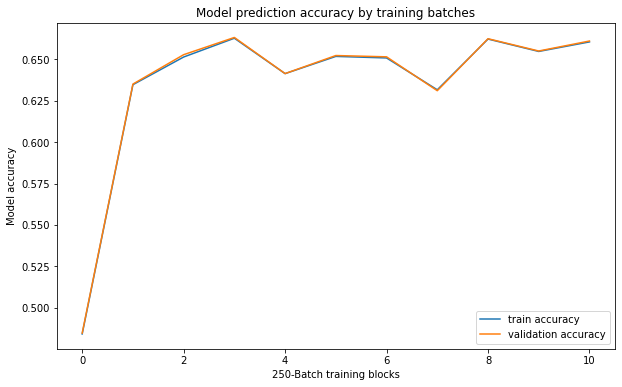

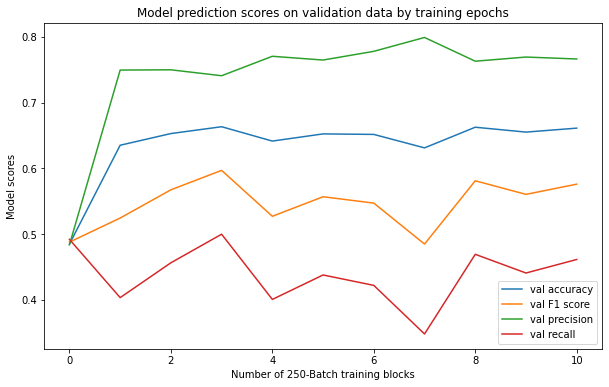


starting batch 1000/1343, Loss=0.6419
Accuracy:   0.6547831106712848
F1_score:   0.5599276725923278
Precision:  0.7687489174989897
Recall:     0.44032010052743836
 Accuracy on training: 65.46%
Accuracy on val: 65.48%


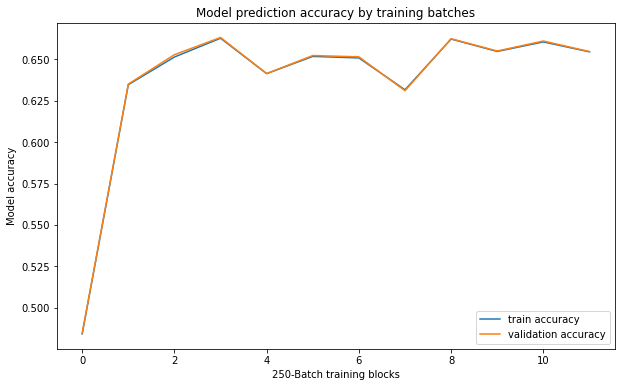

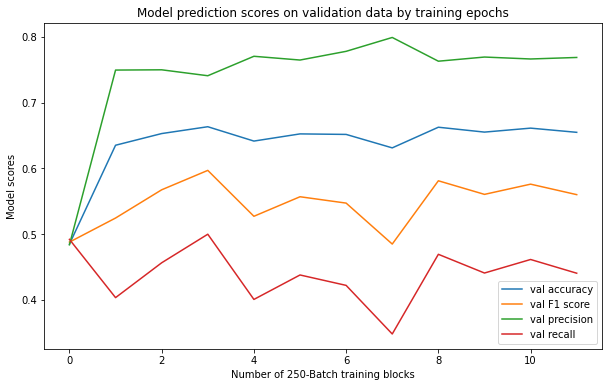

========================= Starting epoch 5 =========================

starting batch 0/1343, Loss=0.5803
Accuracy:   0.6585931057232394
F1_score:   0.5739660193675198
Precision:  0.7600294342090919
Recall:     0.4610869529273656
 Accuracy on training: 65.89%
Accuracy on val: 65.86%


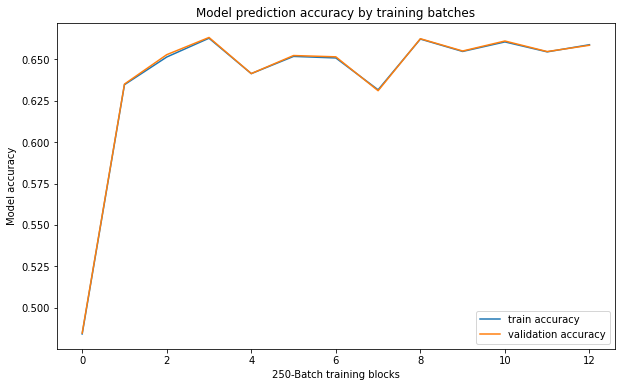

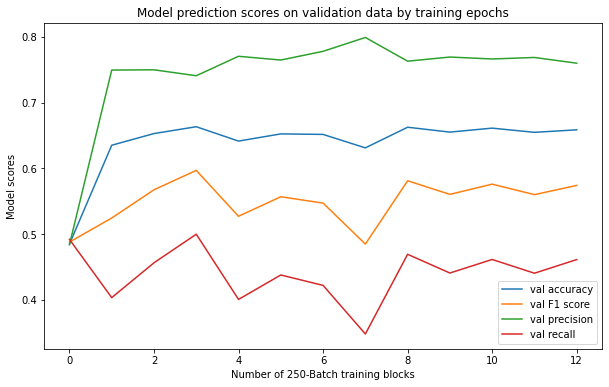


starting batch 500/1343, Loss=0.5742
Accuracy:   0.6551542140854363
F1_score:   0.5617139023981217
Precision:  0.7672001603344117
Recall:     0.44304823002265176
 Accuracy on training: 65.51%
Accuracy on val: 65.52%


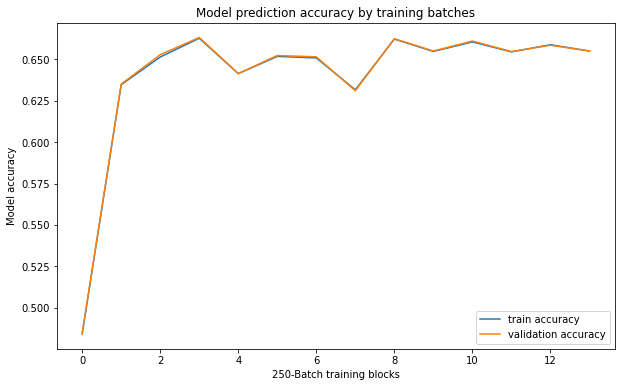

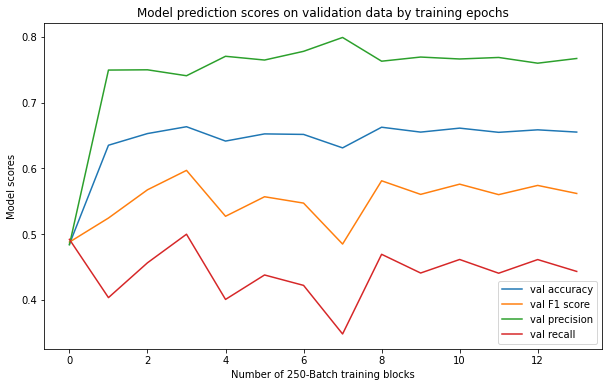

Epoch    14: reducing learning rate of group 0 to 4.0000e-05.

starting batch 1000/1343, Loss=0.5922
========================= Starting epoch 6 =========================

starting batch 0/1343, Loss=0.5530
Accuracy:   0.6592363516411017
F1_score:   0.5770321312683611
Precision:  0.7574438353219392
Recall:     0.4660306542550553
 Accuracy on training: 65.92%
Accuracy on val: 65.92%


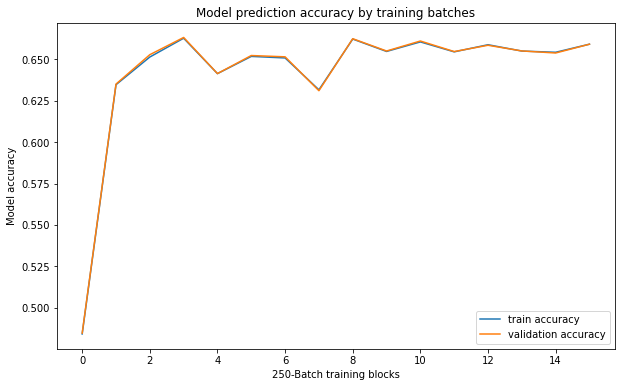

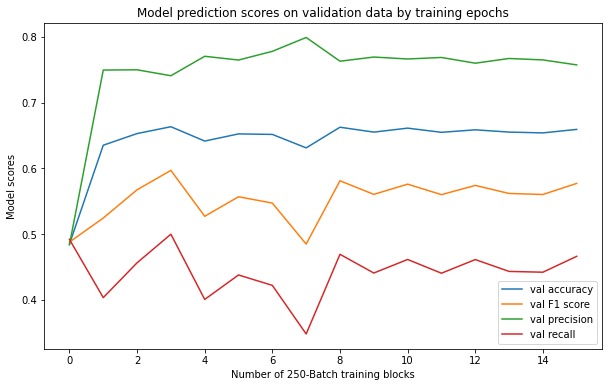


starting batch 500/1343, Loss=0.5898
Accuracy:   0.6549645390070922
F1_score:   0.5632444282060651
Precision:  0.7639463102452285
Recall:     0.4460574395264629
 Accuracy on training: 65.53%
Accuracy on val: 65.50%


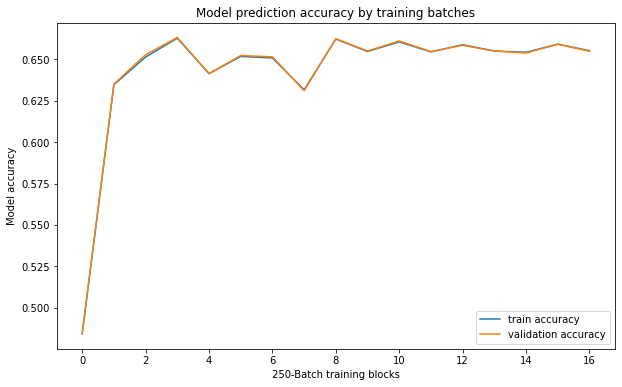

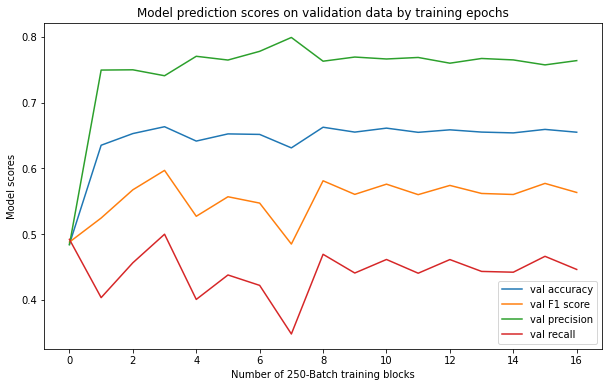


starting batch 1000/1343, Loss=0.5506
Accuracy:   0.6558964209137391
F1_score:   0.5662668135797592
Precision:  0.7625206461185298
Recall:     0.450356310246193
 Accuracy on training: 65.62%
Accuracy on val: 65.59%


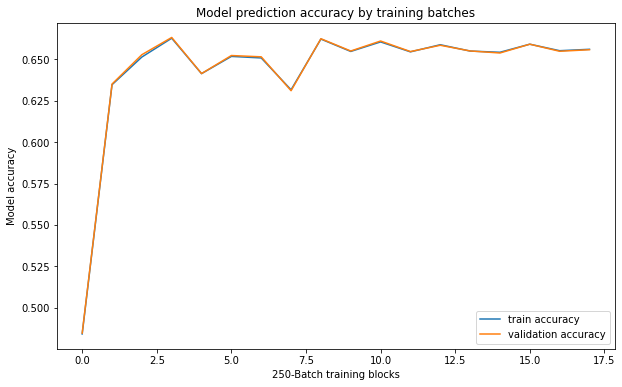

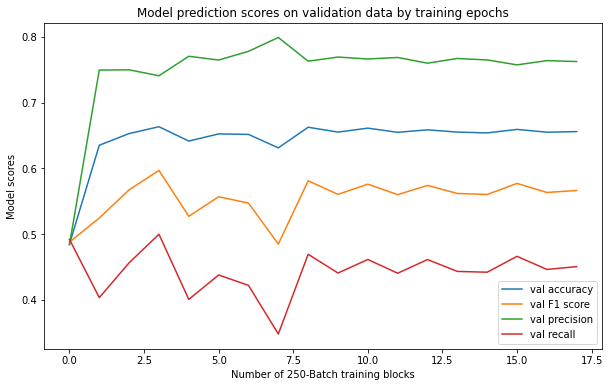

========================= Starting epoch 7 =========================

starting batch 0/1343, Loss=0.5787
Accuracy:   0.6572158997196108
F1_score:   0.5722254240079038
Precision:  0.7577888625398642
Recall:     0.4596650187662241
 Accuracy on training: 65.76%
Accuracy on val: 65.72%


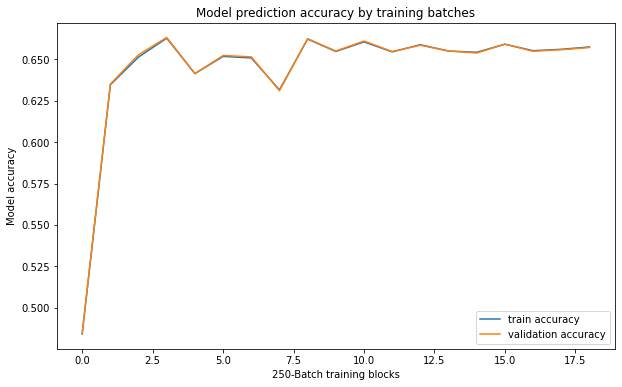

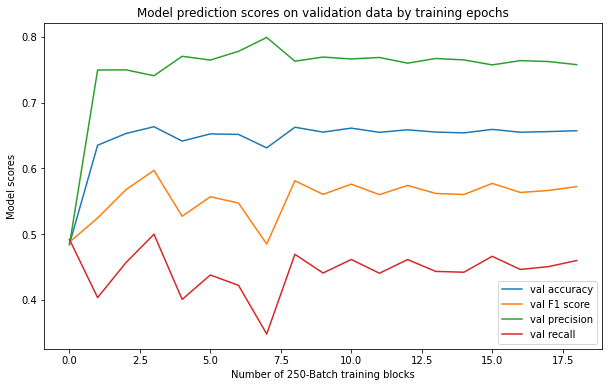

Epoch    19: reducing learning rate of group 0 to 8.0000e-06.

starting batch 500/1343, Loss=0.5780
Accuracy:   0.6574385617681016
F1_score:   0.5716878215769775
Precision:  0.7594652347816558
Recall:     0.45835882343215223
 Accuracy on training: 65.77%
Accuracy on val: 65.74%


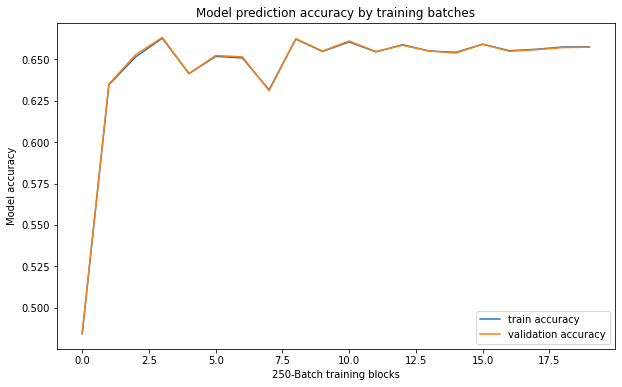

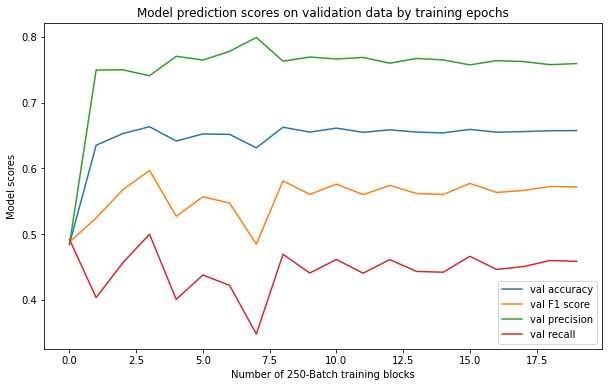


starting batch 1000/1343, Loss=0.6146
Accuracy:   0.6566798614547253
F1_score:   0.5704291477923498
Precision:  0.7587011418533157
Recall:     0.4570195598617748
 Accuracy on training: 65.70%
Accuracy on val: 65.67%


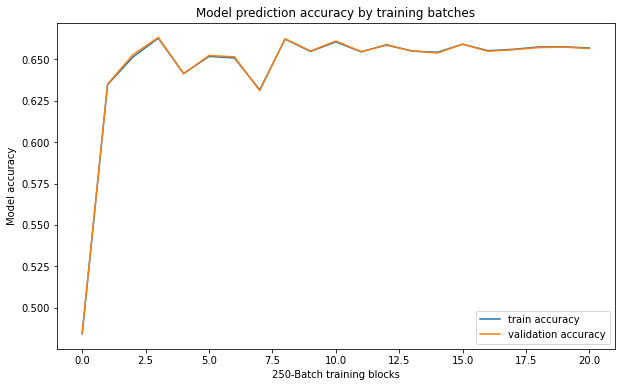

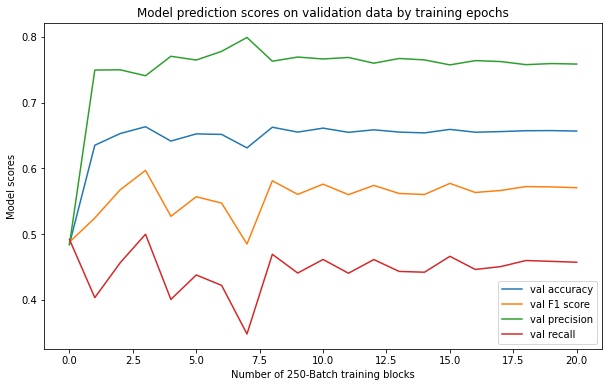

========================= Starting epoch 8 =========================

starting batch 0/1343, Loss=0.6034
Accuracy:   0.6578508988949365
F1_score:   0.5737592077010798
Precision:  0.7576514000434122
Recall:     0.4616987152990195
 Accuracy on training: 65.82%
Accuracy on val: 65.79%


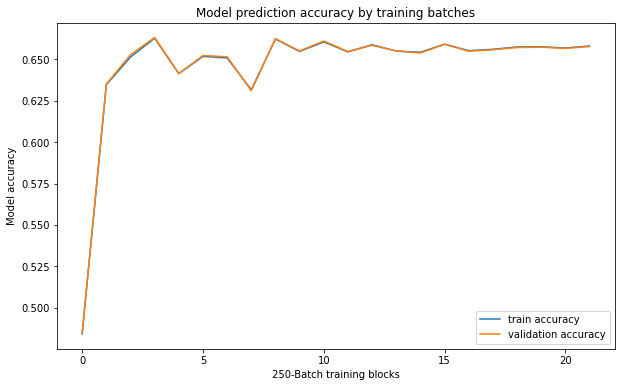

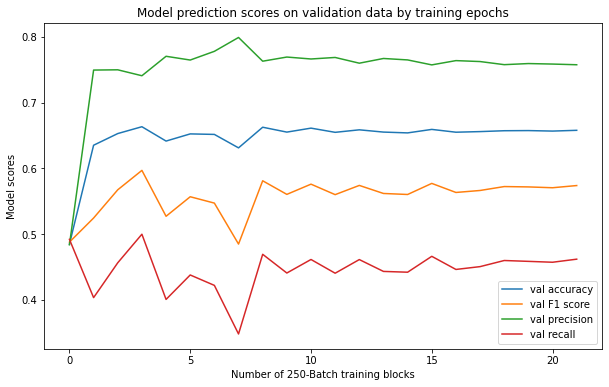


starting batch 500/1343, Loss=0.5698
Accuracy:   0.657372587827808
F1_score:   0.5723637486490659
Precision:  0.7581392812346621
Recall:     0.4597146211206825
 Accuracy on training: 65.77%
Accuracy on val: 65.74%


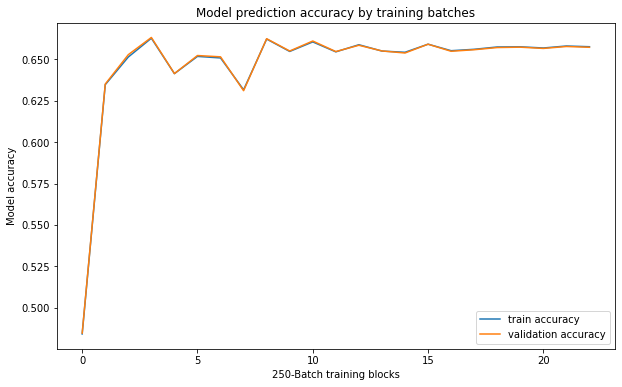

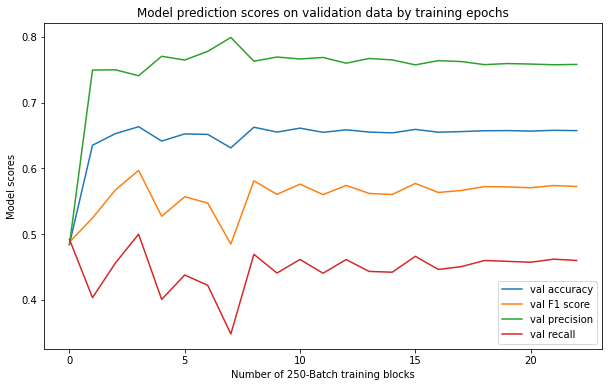


starting batch 1000/1343, Loss=0.5961
Accuracy:   0.6575375226785419
F1_score:   0.5727367197226139
Precision:  0.7581444759206799
Recall:     0.46019411054711395
 Accuracy on training: 65.78%
Accuracy on val: 65.75%


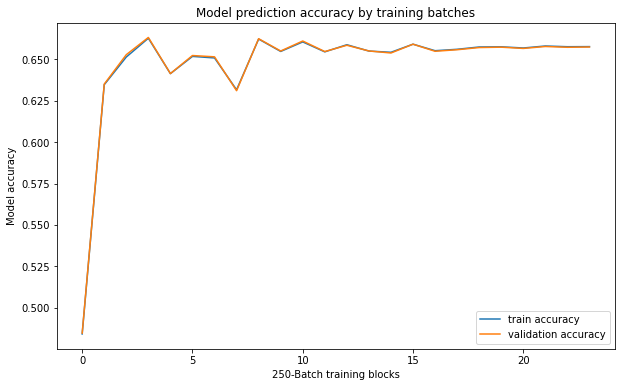

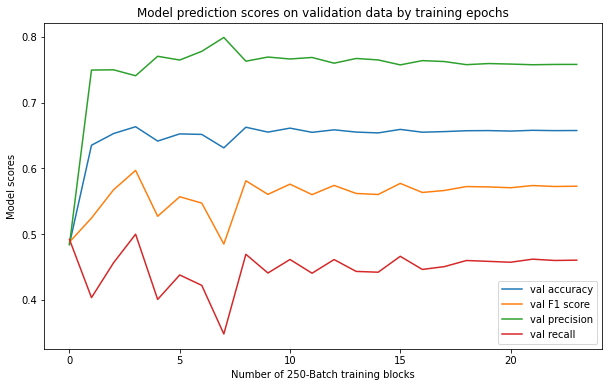

Epoch    24: reducing learning rate of group 0 to 1.6000e-06.
Accuracy:   0.6576199901039089
F1_score:   0.5736817785079839
Precision:  0.7569369174073272
Recall:     0.4618640564805476
 Accuracy on training: 65.78%
Accuracy on val: 65.76%


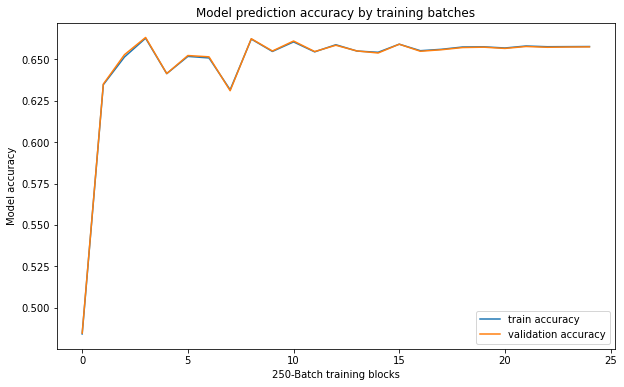

Accuracy:   0.6566056407718951
F1_score:   0.5684347988309185
Precision:  0.7616442160810999
Recall:     0.45341512210446255
 Accuracy on training: 65.67%
Accuracy on val: 65.66%


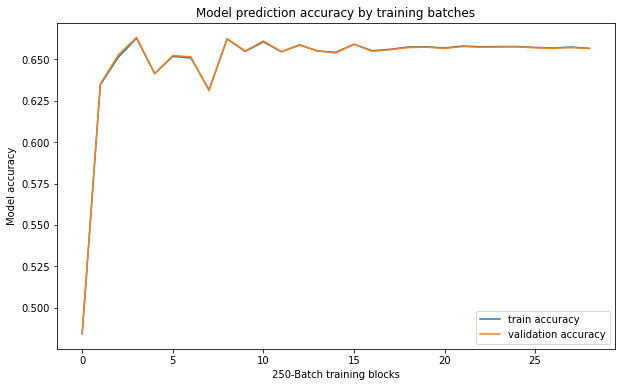

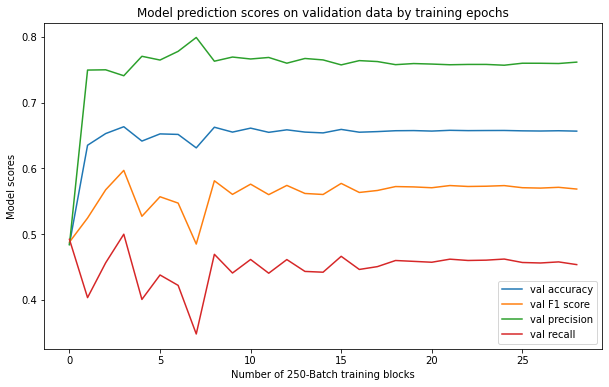

Epoch    29: reducing learning rate of group 0 to 3.2000e-07.

starting batch 1000/1343, Loss=0.5927
Accuracy:   0.6572158997196108
F1_score:   0.5719082145505479
Precision:  0.7582957804178615
Recall:     0.459069790512723
 Accuracy on training: 65.75%
Accuracy on val: 65.72%


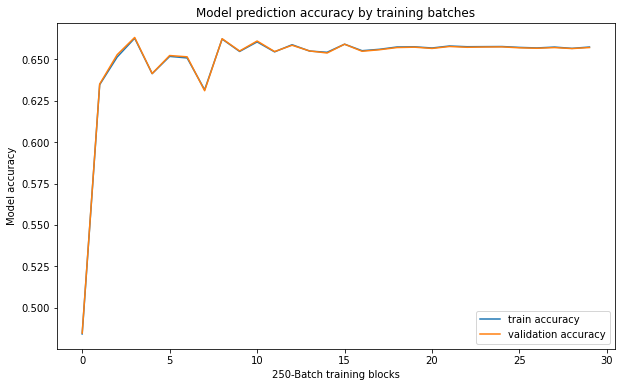

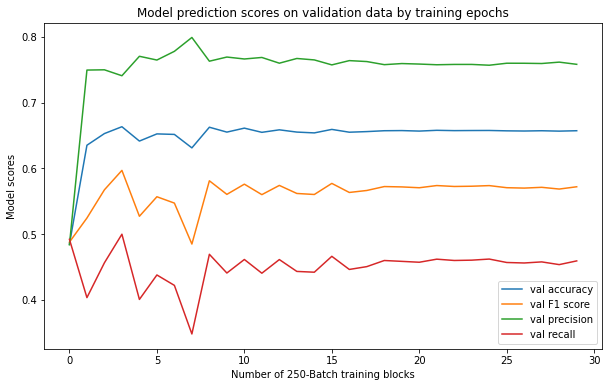

========================= Starting epoch 11 =========================

starting batch 0/1343, Loss=0.5476
Accuracy:   0.6575292759360053
F1_score:   0.5732226173103405
Precision:  0.7573387644263408
Recall:     0.46112002116367123
 Accuracy on training: 65.77%
Accuracy on val: 65.75%


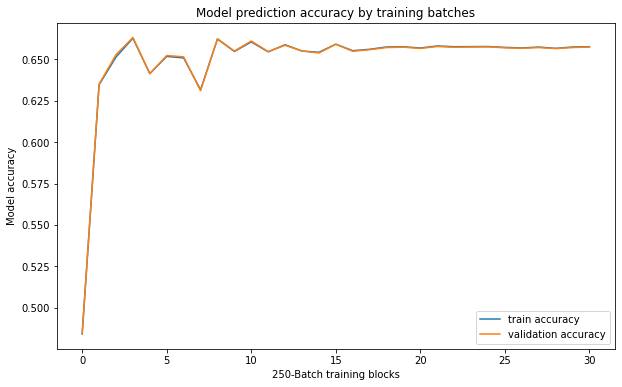

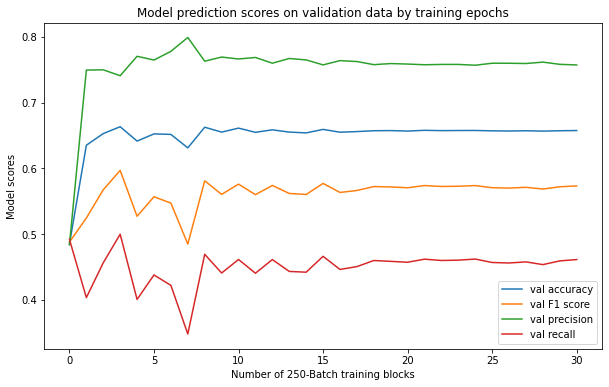


starting batch 500/1343, Loss=0.5805
Accuracy:   0.6569849909285832
F1_score:   0.5707179127275729
Precision:  0.7593584356375821
Recall:     0.4571518328069972
 Accuracy on training: 65.74%
Accuracy on val: 65.70%


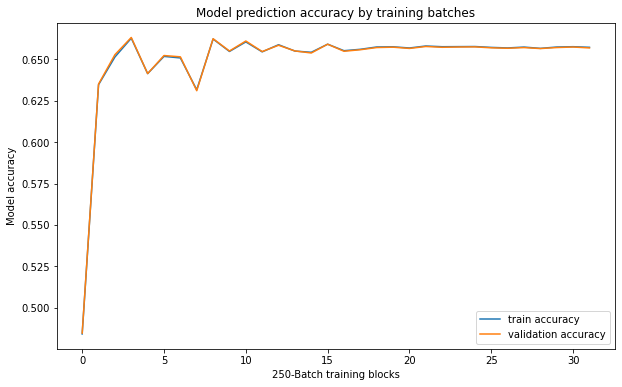

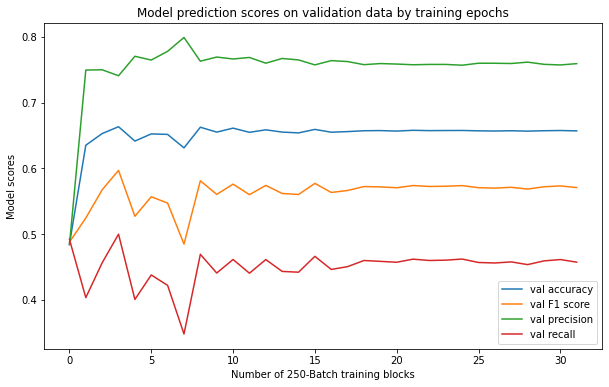


starting batch 1000/1343, Loss=0.5681
Accuracy:   0.6573313541151246
F1_score:   0.5717966157587749
Precision:  0.7588970648576197
Recall:     0.45870603991336123
 Accuracy on training: 65.76%
Accuracy on val: 65.73%


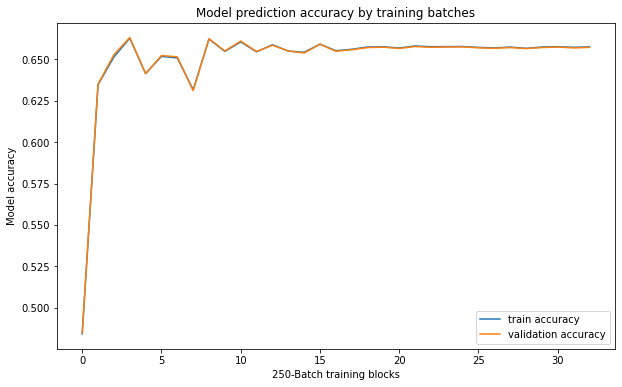

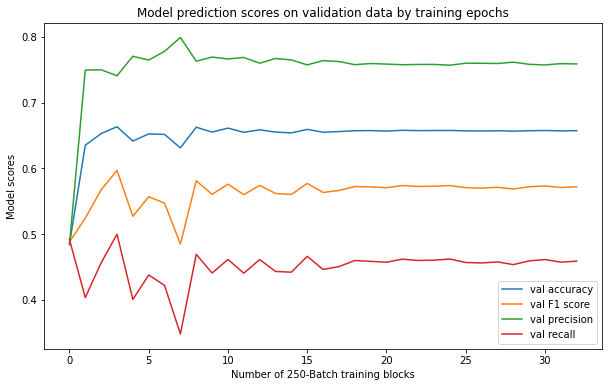

========================= Starting epoch 12 =========================

starting batch 0/1343, Loss=0.5994

starting batch 500/1343, Loss=0.5806
Accuracy:   0.6573560943427346
F1_score:   0.5726686482428082
Precision:  0.7575922499183629
Recall:     0.4603098493741836
 Accuracy on training: 65.76%
Accuracy on val: 65.74%
Accuracy:   0.6567128484248722
F1_score:   0.5688421183465048
Precision:  0.7613819109410526
Recall:     0.45402688447611644
 Accuracy on training: 65.72%
Accuracy on val: 65.67%


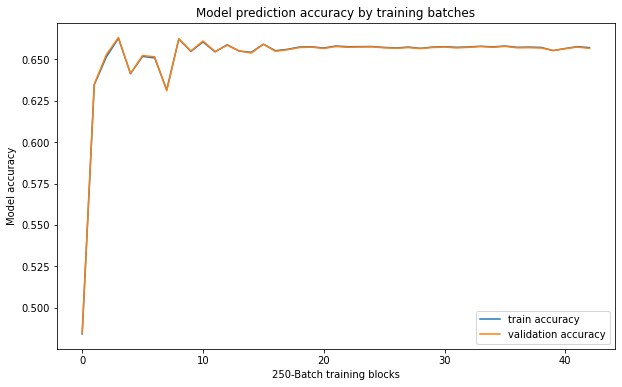

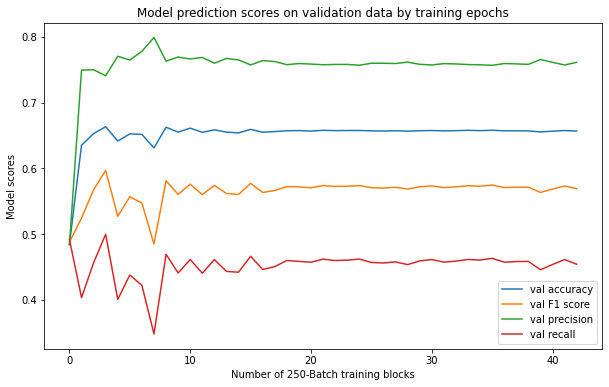


starting batch 500/1343, Loss=0.5976
Accuracy:   0.6573066138875144
F1_score:   0.5724838221828994
Precision:  0.75770697167756
Recall:     0.4600287693655859
 Accuracy on training: 65.76%
Accuracy on val: 65.73%


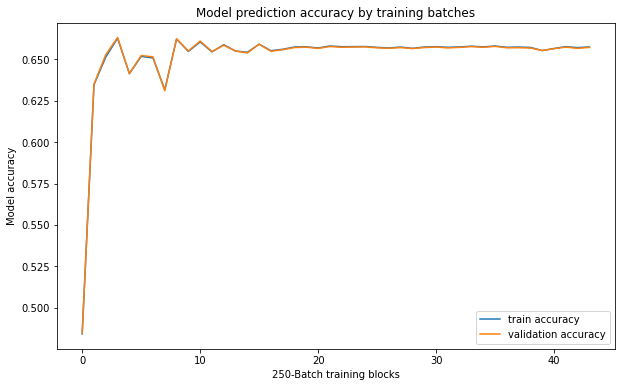

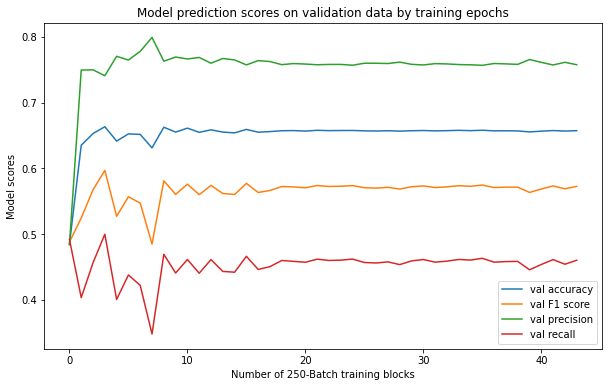

Epoch    44: reducing learning rate of group 0 to 2.5600e-09.

starting batch 1000/1343, Loss=0.5837
Accuracy:   0.6570921985815603
F1_score:   0.5712370719434106
Precision:  0.7589182968929804
Recall:     0.4579785387146377
 Accuracy on training: 65.74%
Accuracy on val: 65.71%


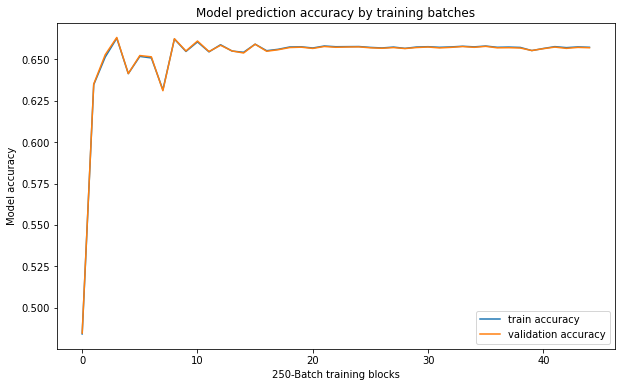

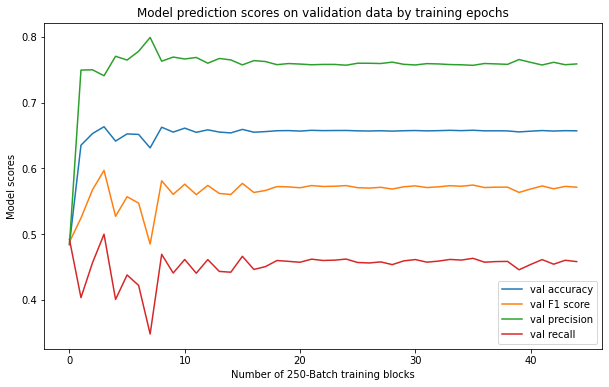

========================= Starting epoch 16 =========================

starting batch 0/1343, Loss=0.5749
Accuracy:   0.657100445324097
F1_score:   0.5721253781720143
Precision:  0.7575278633130773
Recall:     0.4596319505299185
 Accuracy on training: 65.74%
Accuracy on val: 65.71%


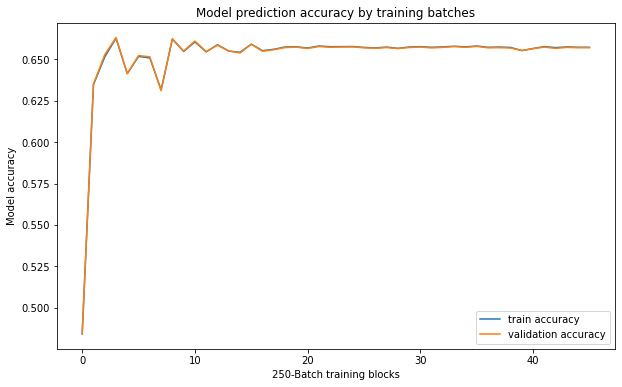

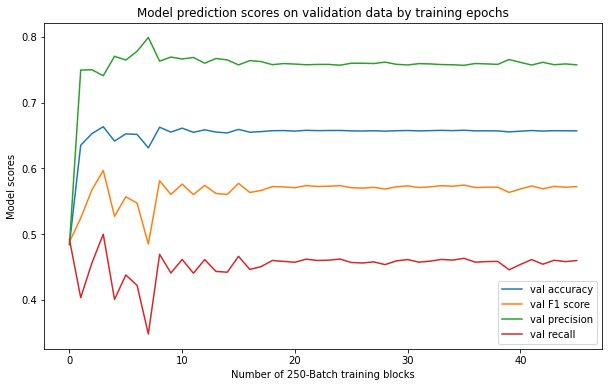

In [ ]:
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu')
nn_model = nn_model.to(device)

train_cnn(nn_model.double(), train_loader, val_loader, val_loader, device, num_epochs=200, lr=0.001)

In [ ]:
type(torch.randn(3, 10, 10)[0][1, 1].item())